In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
folder_path = '/content/drive/MyDrive/Electricity-Power'
os.chdir(folder_path)


Mounted at /content/drive


# NOTE
Stacker models haven't been run in this notebook due to their time consuming runtime. however they have been executed in other notebooks and you can see the results.

## Code Aggregation

Starting pipeline...
 Selected Model: random_forest
 Shape of Train set: (15241, 66)
 Shape of Test set: (3811, 66)
 Number of Tragets: 15
Training the model...
Model training is complete.
Feature Importances:
                                              feature  importance
37                                 neighbor_price_avg    0.497953
55                            conventional Generation    0.138625
50             Actual_consumption_Residual load [MWh]    0.047408
31                    Actual_generation_Lignite [MWh]    0.043437
12                 Actual_generation_Fossil gas [MWh]    0.028697
..                                                ...         ...
40                      price_lag_168hAustria [€/MWh]    0.001620
21    Installed_generation_capacity_Wind onshore [MW]    0.001161
32  Manual_Frequency_Restoration_Reserve_Volume pr...    0.000972
60  Automatic_Frequency_Restoration_Reserve_Procur...    0.000873
42  Automatic_Frequency_Restoration_Reserve_Volume...    0.00083

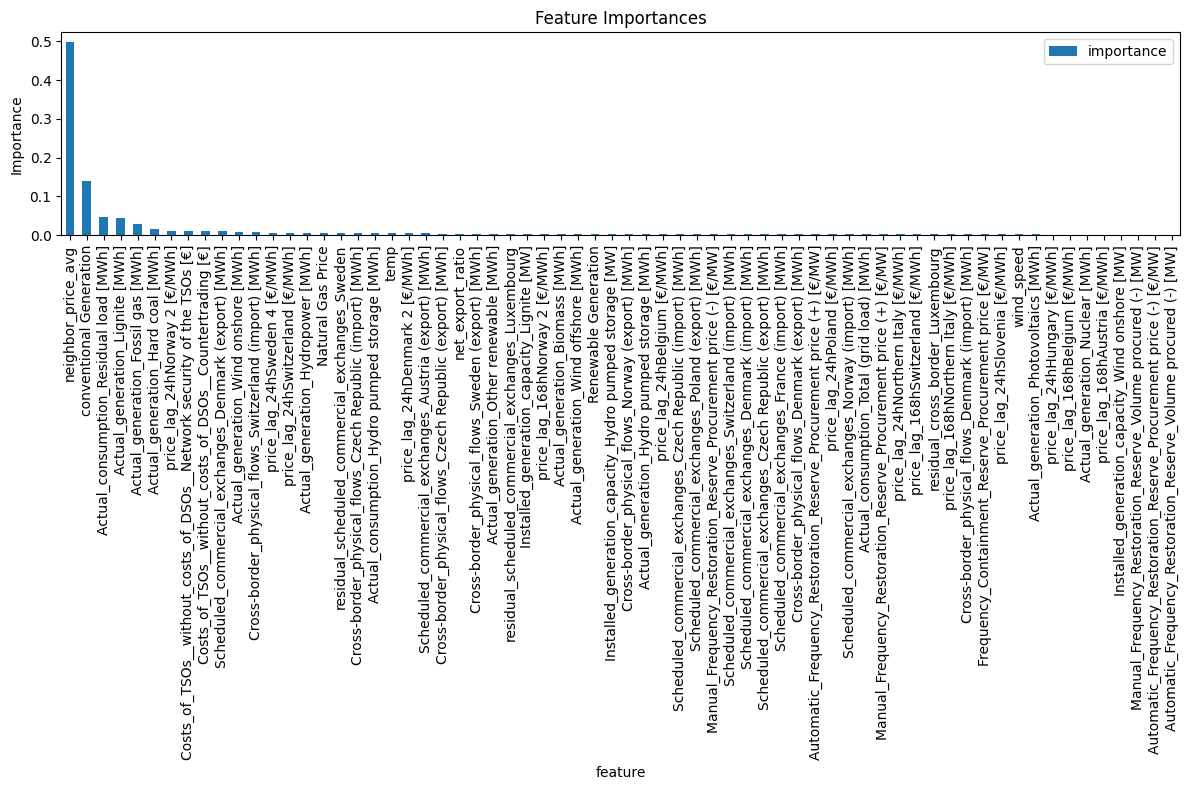

Making predictions...
Root Mean Square Error: 13.256162831763675
Mean Squared Error: 175.7258530222327
Mean Absolute Error: 7.447923356949184
R² Score: 0.9274103381836498
Total extreme price movment accuracy: 100.00%

Analyzing directional prediction accuracy...

Directional Accuracy for Day-ahead_prices_Switzerland [€/MWh]:
Overall: 91.76%
Rising: 93.16% (1689/1813)
Falling: 92.57% (1806/1951)
Stable: 4.26% (2/47)

Directional Accuracy for Day-ahead_prices_Netherlands [€/MWh]:
Overall: 89.40%
Rising: 90.89% (1556/1712)
Falling: 90.36% (1846/2043)
Stable: 8.93% (5/56)

Directional Accuracy for Day-ahead_prices_∅ DE/LU neighbours [€/MWh]:
Overall: 96.80%
Rising: 97.97% (1786/1823)
Falling: 97.17% (1889/1944)
Stable: 31.82% (14/44)

Directional Accuracy for Day-ahead_prices_Belgium [€/MWh]:
Overall: 90.84%
Rising: 92.33% (1625/1760)
Falling: 91.64% (1831/1998)
Stable: 11.32% (6/53)

Directional Accuracy for Day-ahead_prices_Sweden 4 [€/MWh]:
Overall: 85.02%
Rising: 87.63% (1509/1722)
Fal

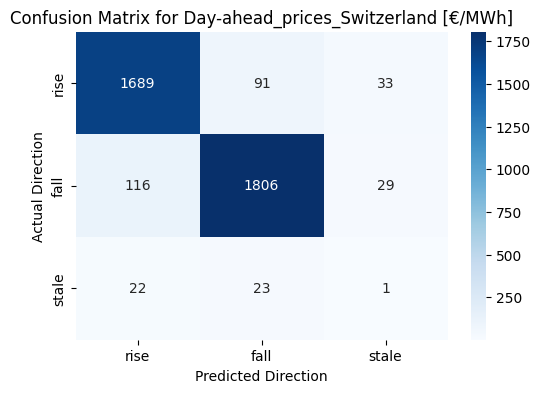

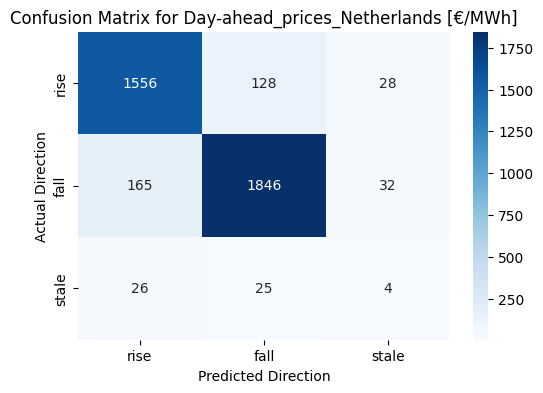

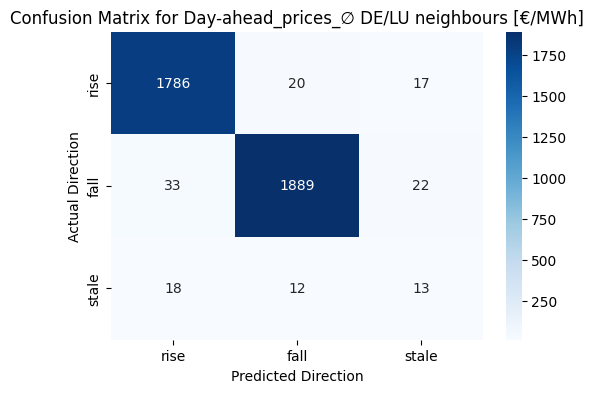

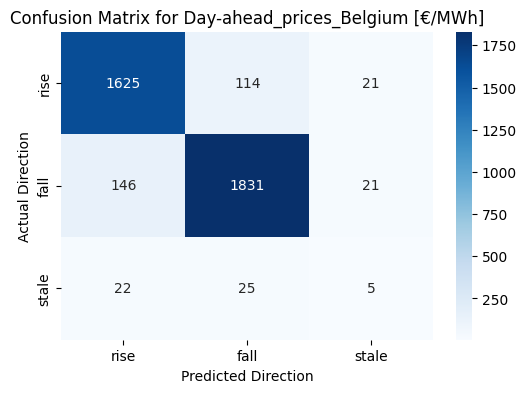

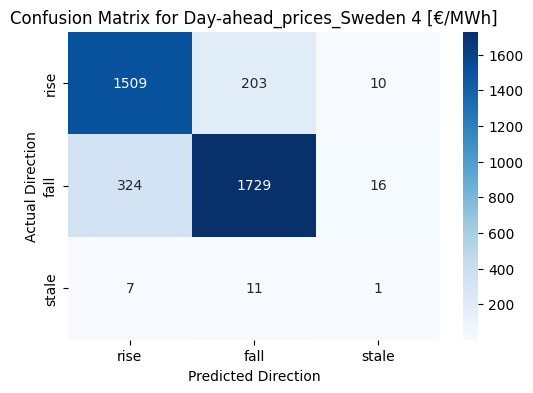

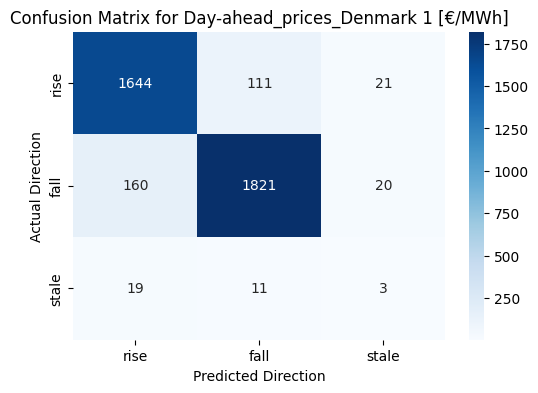

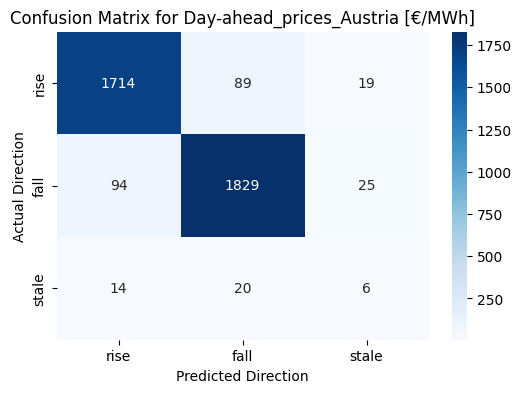

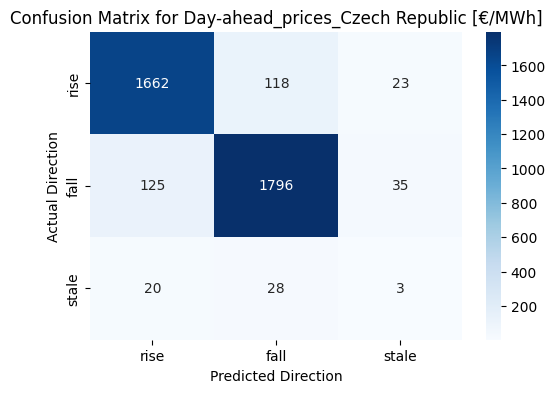

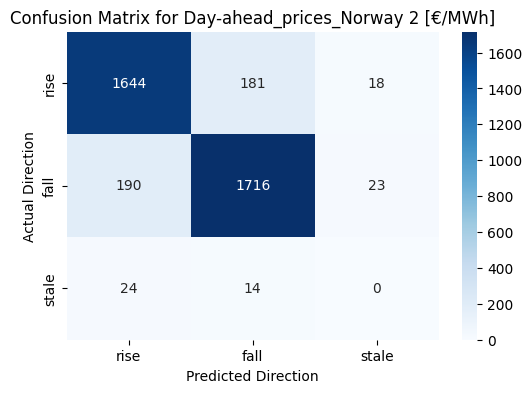

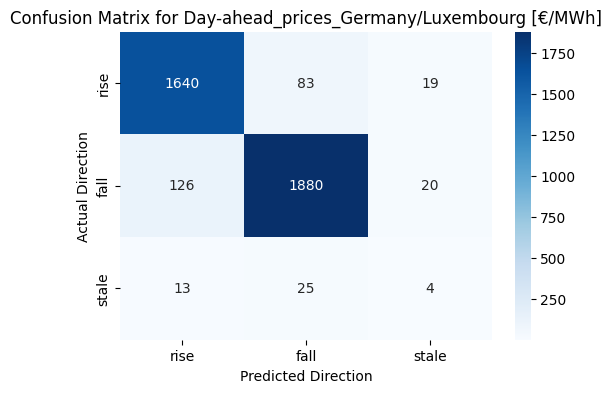

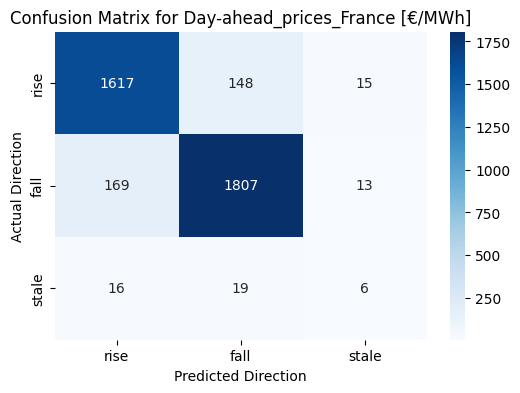

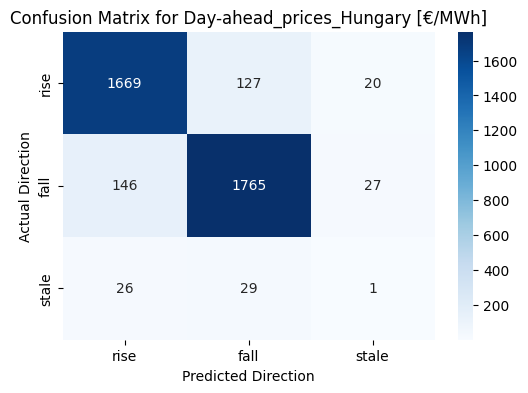

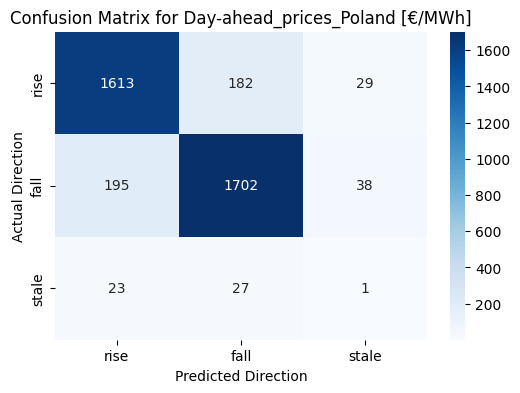

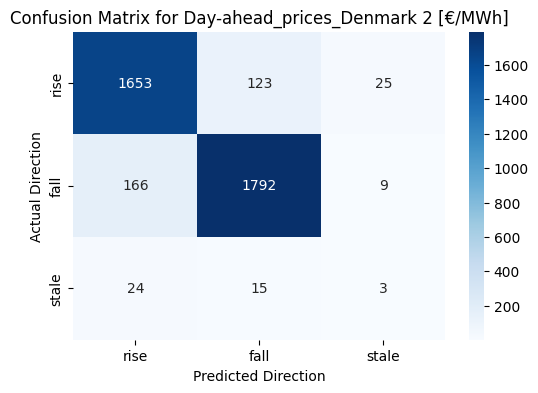

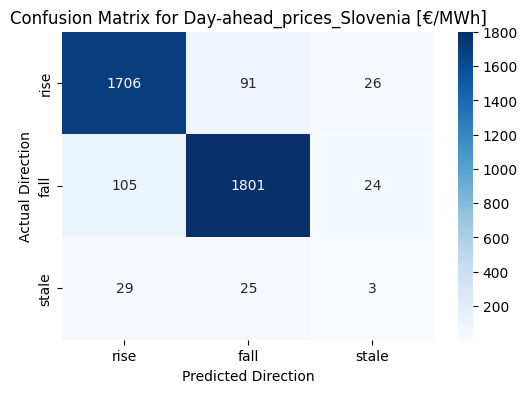

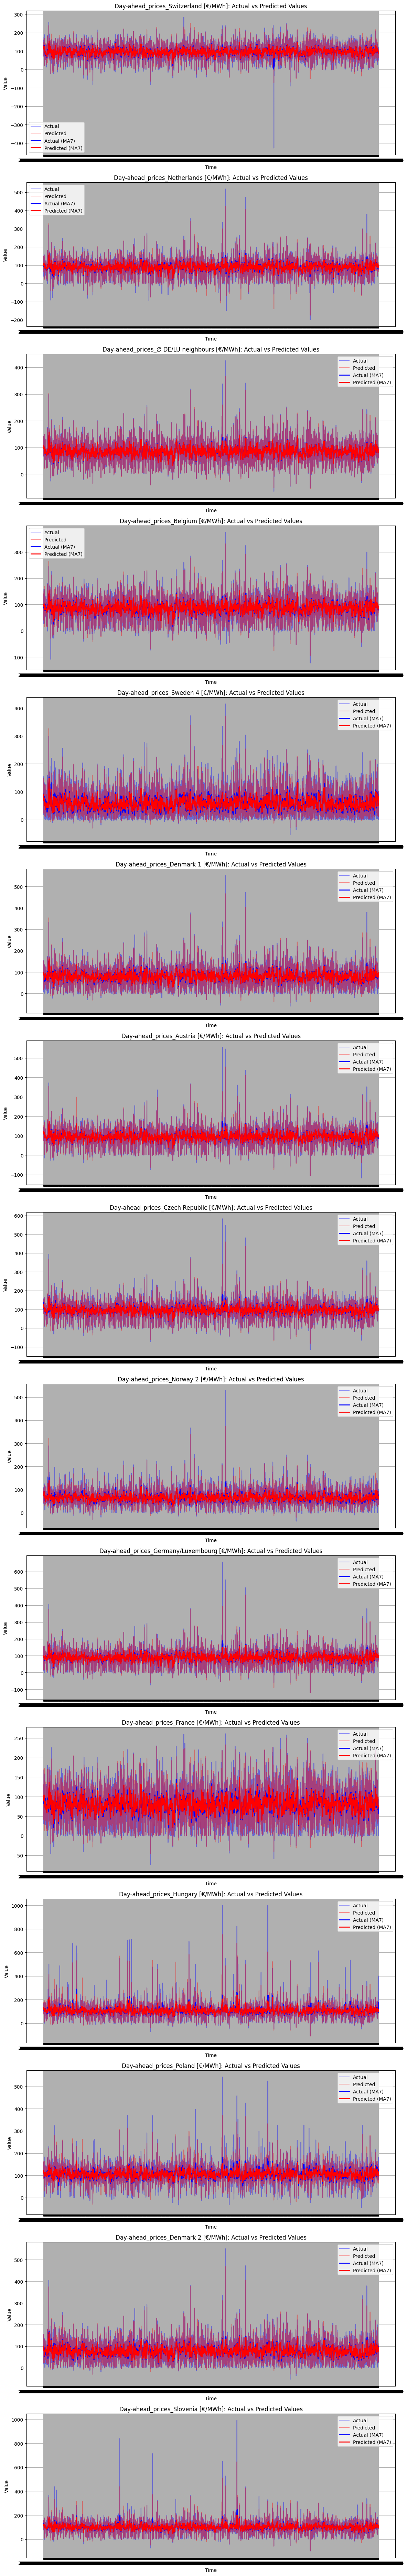

Starting pipeline...
 Selected Model: xgboost
 Shape of Train set: (15241, 66)
 Shape of Test set: (3811, 66)
 Number of Tragets: 15
Training the model...
Model training is complete.
Feature Importances:
                                              feature  importance
37                                 neighbor_price_avg    0.201581
26           Installed_generation_capacity_Lignite MW    0.129349
9                         price_lag_24hNorway 2 €/MWh    0.031897
57  Costs_of_TSOs__without_costs_of_DSOs__Network ...    0.028521
50               Actual_consumption_Residual load MWh    0.028400
..                                                ...         ...
0                          price_lag_24hBelgium €/MWh    0.004388
38   Cross-border_physical_flows_Denmark (export) MWh    0.004207
44  Frequency_Containment_Reserve_Procurement pric...    0.003973
42  Automatic_Frequency_Restoration_Reserve_Volume...    0.003582
32  Manual_Frequency_Restoration_Reserve_Volume pr...    0.003024

[66

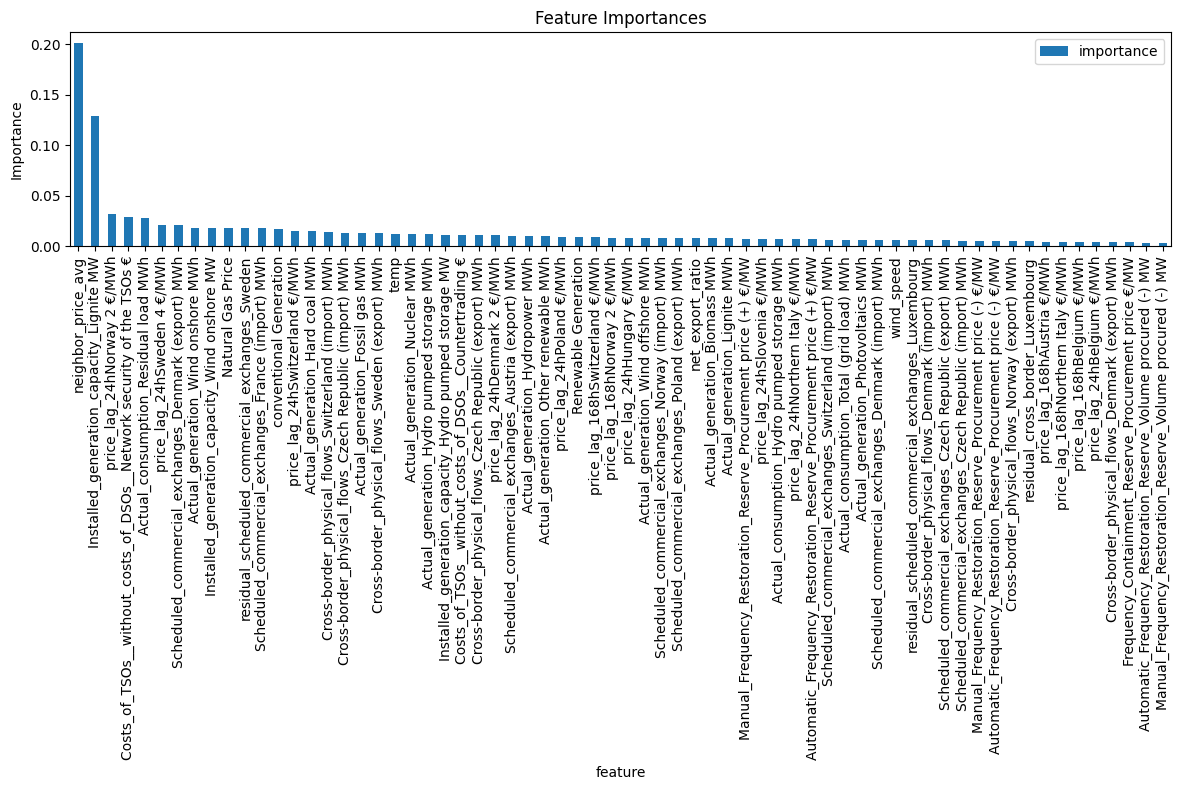

Making predictions...
Root Mean Square Error: 14.139023818162364
Mean Squared Error: 199.91199453056262
Mean Absolute Error: 8.376427031638036
R² Score: 0.9161608301168439
Total extreme price movment accuracy: 100.00%

Analyzing directional prediction accuracy...

Directional Accuracy for Day-ahead_prices_Switzerland €/MWh:
Overall: 91.42%
Rising: 91.78% (1664/1813)
Falling: 92.88% (1812/1951)
Stable: 17.02% (8/47)

Directional Accuracy for Day-ahead_prices_Netherlands €/MWh:
Overall: 87.90%
Rising: 89.37% (1530/1712)
Falling: 88.94% (1817/2043)
Stable: 5.36% (3/56)

Directional Accuracy for Day-ahead_prices_∅ DE/LU neighbours €/MWh:
Overall: 96.77%
Rising: 97.64% (1780/1823)
Falling: 97.58% (1897/1944)
Stable: 25.00% (11/44)

Directional Accuracy for Day-ahead_prices_Belgium €/MWh:
Overall: 90.13%
Rising: 91.14% (1604/1760)
Falling: 91.24% (1823/1998)
Stable: 15.09% (8/53)

Directional Accuracy for Day-ahead_prices_Sweden 4 €/MWh:
Overall: 83.47%
Rising: 82.98% (1429/1722)
Falling: 84

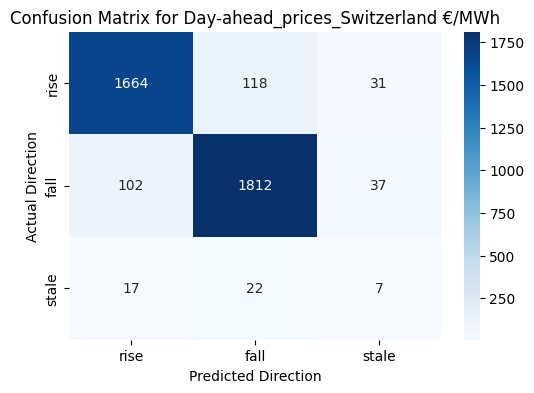

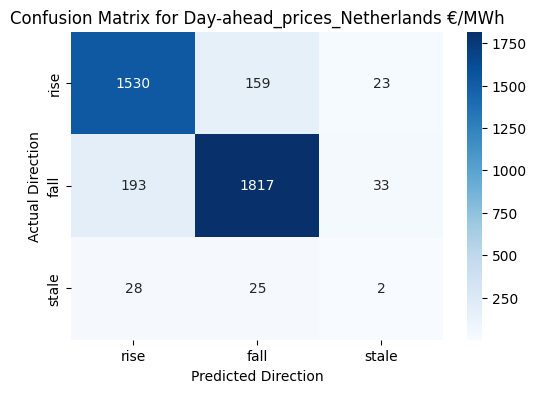

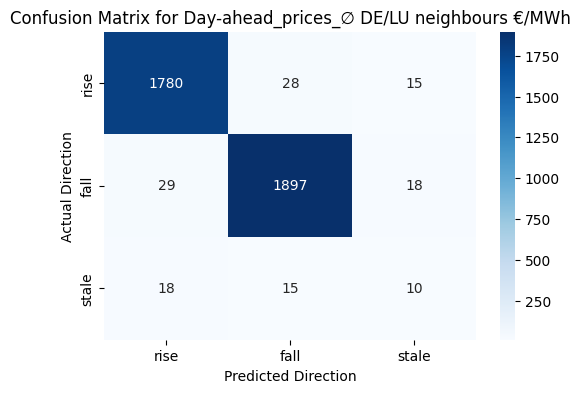

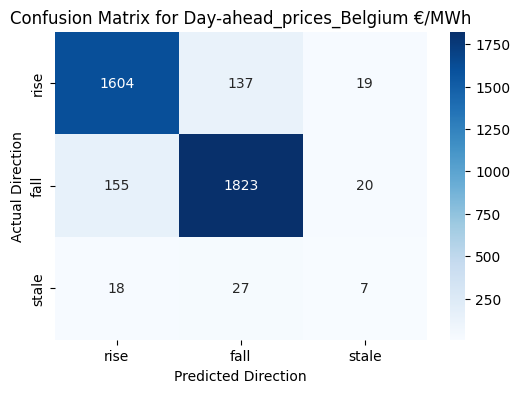

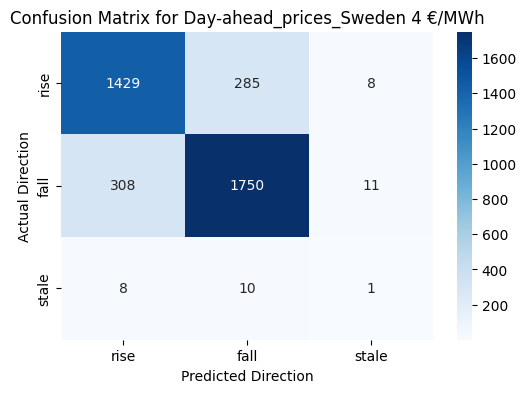

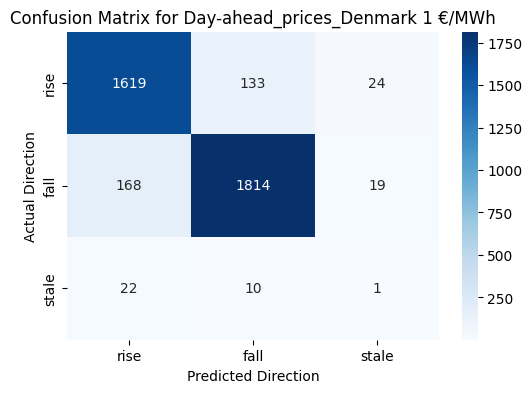

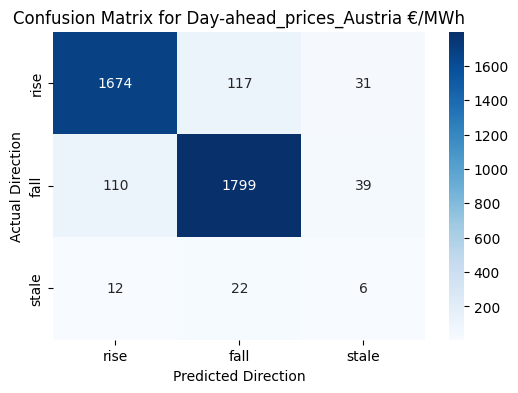

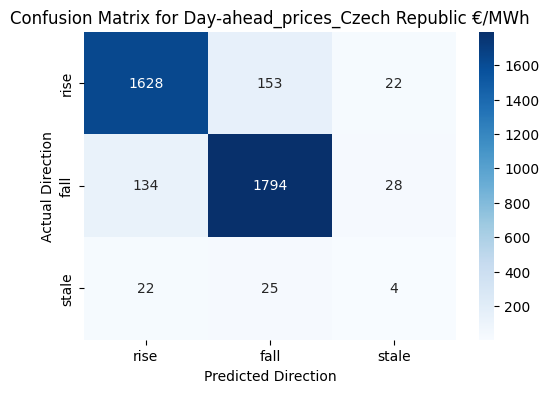

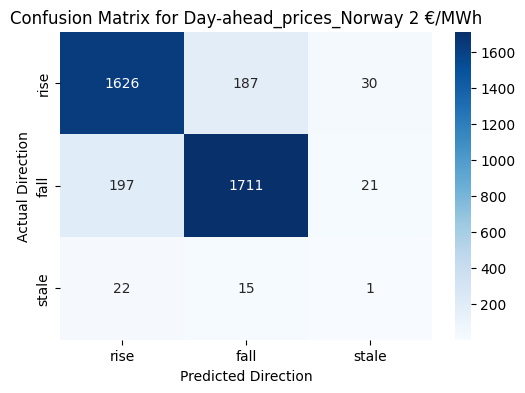

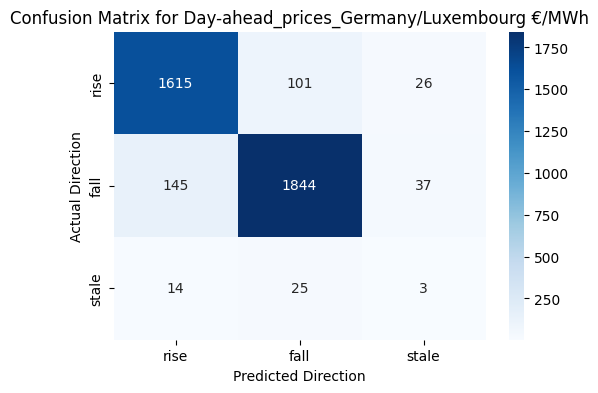

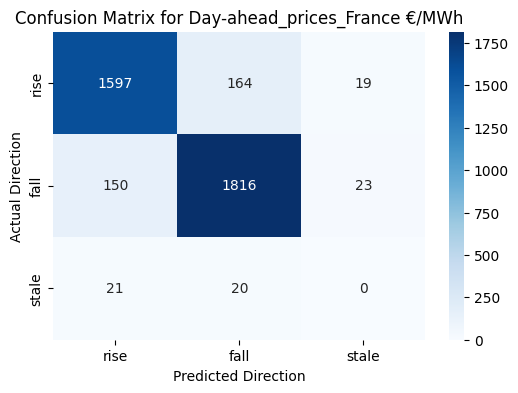

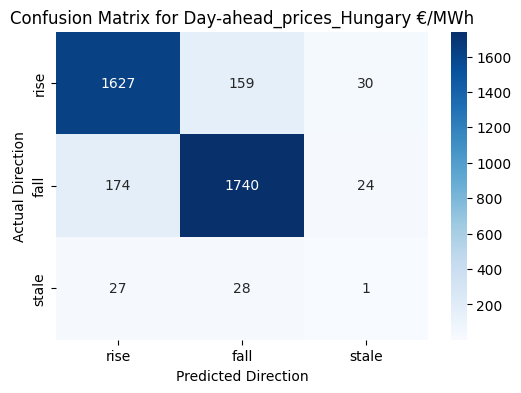

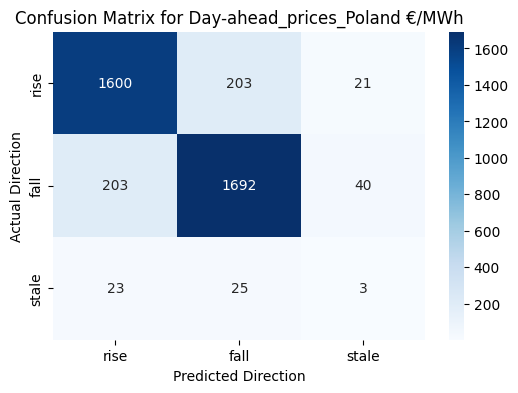

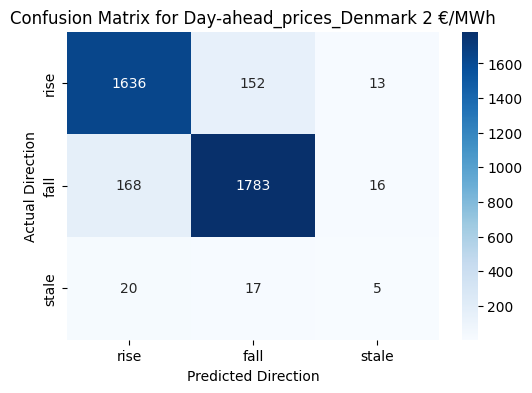

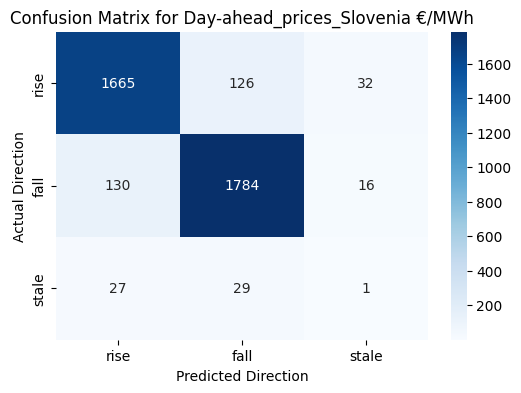

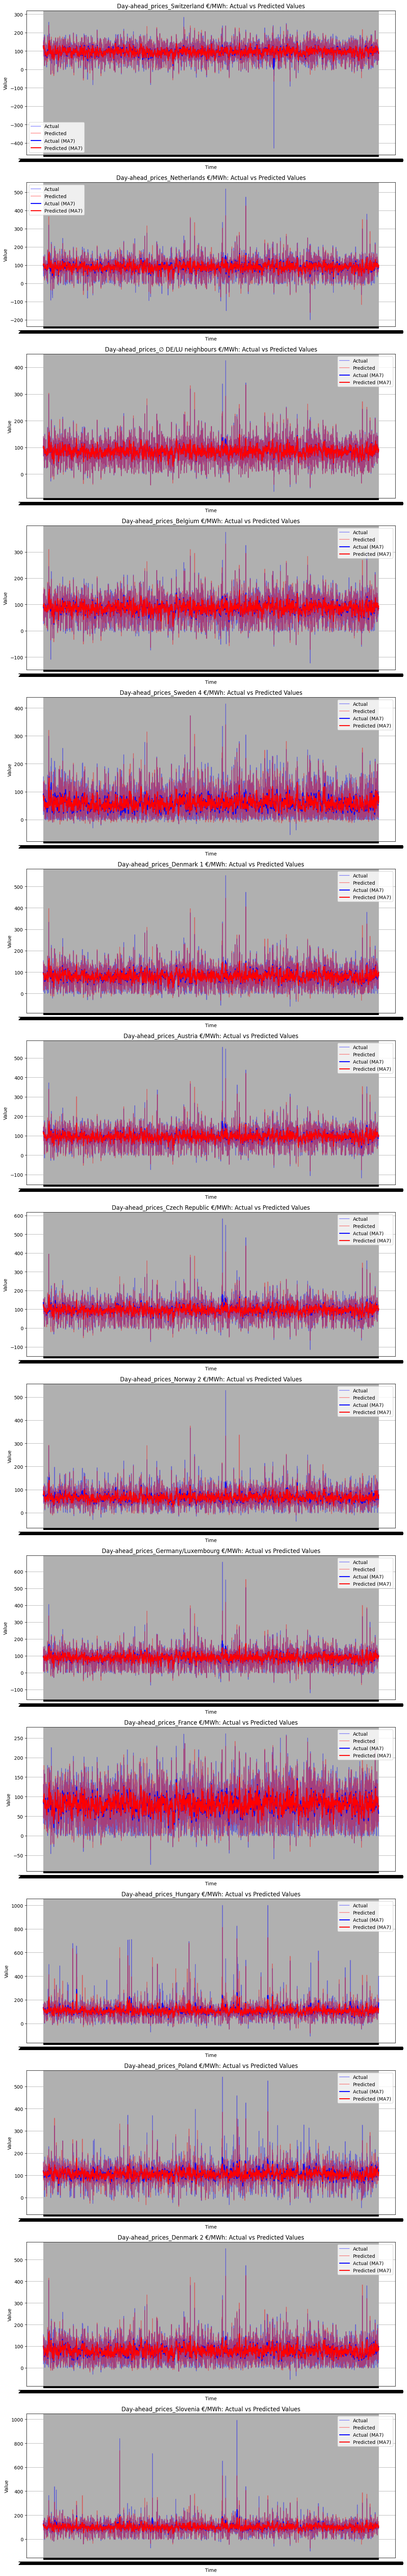

In [5]:
import os
import pickle
import requests
from zipfile import ZipFile
from tqdm import tqdm
import warnings
import numpy as np
import numpy
from scipy import stats
from scipy.stats import mstats
import math
warnings.filterwarnings("ignore")
import json
import pandas as pd
import pickle
import seaborn as sns
import random
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import gc
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge

import lime.lime_tabular
random.seed(42)
from sklearn.decomposition import PCA
np.random.seed(42)
black = '\033[30m'
red = '\033[31m'
green = '\033[32m'
yellow = '\033[33m'
blue = '\033[34m'
magenta = '\033[35m'
cyan = '\033[36m'
white = '\033[37m'
orange = "\033[38;5;208m"
bold = '\033[1m'
reset = '\033[0m'

# -----------------------------------model & analysis Function------------

def model_pipeline(model_type, df, target, cross_val=False, grid_search=False, transform=False):
    # Check if all target columns exist in the dataframe
    if all(cols in df.columns for cols in target):
        print('Starting pipeline...')
    else:
        raise ValueError("Some target columns are missing in the dataframe.")

    # Transformation step (if enabled)
    if transform:
        print("Applying transformations to targets...")
        original_target = df[target].copy()

        # Apply Box-Cox transformation to each target column
        boxcox_lambdas = {}
        for col in target:
            df[col] = df[col].apply(lambda x: x if x >= 0 else 0)
            df[col], boxcox_lambda = stats.boxcox(df[col] + 1)
            boxcox_lambdas[col] = boxcox_lambda
            lower_percentile = np.percentile(df[col], 1)
            upper_percentile = np.percentile(df[col], 99)
            df[col] = np.clip(df[col], lower_percentile, upper_percentile)

        # Scale the transformed targets
        scaler = StandardScaler()
        df[target] = scaler.fit_transform(df[target])

    # Splitting data into features (X) and targets (y)
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f' {green}Selected Model:{reset} {bold}{model_type}{reset}')
    print(f' {green}Shape of Train set: {reset}{bold}{X_train.shape}{reset}')
    print(f'{green} Shape of Test set:{reset} {bold}{X_test.shape}{reset}')
    print(f' {green}Number of Tragets:{reset} {bold}{len(target)}{reset}')

    if transform:
        y_test_original = original_target.loc[y_test.index]
    else:
        y_test_original = y_test

    # Further split for grid search (if applicable)
    X_grid, _, y_grid, _ = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

    # Define model and parameter grid based on selected model type
    if model_type.lower() == 'random_forest':
        model = RandomForestRegressor(n_estimators=100,
                                      random_state=42,
                                      max_depth= None,
                                      max_features= 0.5,
                                      min_samples_leaf= 1,
                                      min_samples_split= 2,
                                      )
        param_grid = {
            'n_estimators': [100],
            'max_depth': [None, 2, 4],
            'min_samples_split': [2, 4],
            'min_samples_leaf': [1, 3],
            'max_features': ['auto', 'sqrt', 0.5, 0.75, 1.0]
        }
    elif model_type.lower() == 'xgboost':
        model = XGBRegressor(n_estimators=100,
                             random_state=42,
                             gamma=0,
                             learning_rate=0.1,
                             max_depth=4,
                             subsample=0.5)
        param_grid = {
            'n_estimators': [100],
            'max_depth': [2, 4],
            'learning_rate': [0.01, 0.1],
            'gamma': [0, 1.0],
            'subsample': [0.5, 1.0]
        }

    else:
        raise ValueError("Unsupported model_type. Choose from 'random_forest', 'xgboost', or 'catboost'.")

    # Perform grid search hyperparameter tuning (if enabled)
    if grid_search:
        print("Starting grid search for hyperparameter tuning...")
        print('Data for grid search:', X_grid.shape)
        grid = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1)
        grid.fit(X_grid, y_grid)
        print("Best parameters from Grid Search:", grid.best_params_)
        best_model = grid.best_estimator_
    else:
        best_model = model

    # Perform cross-validation (if enabled)
    if cross_val:
        print("Performing 5-fold cross-validation...")
        cv_scores = cross_val_score(best_model,
                                    X,
                                    y,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    n_jobs=-1)
        print("Cross Validation Scores (neg MSE):", cv_scores)
        print("Mean CV Score (neg MSE):", cv_scores.mean())

    # Train the final model on the training set
    print("Training the model...")
    best_model.fit(X_train, y_train)

    print("Model training is complete.")

    # Feature importance extraction and visualization
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
        imp_df = pd.DataFrame({'feature': X_train.columns,
                               'importance': importances})
        imp_df.sort_values(by='importance', ascending=False, inplace=True)

        print("Feature Importances:")
        print(imp_df)

        imp_df.plot(kind='bar', x='feature', y='importance', figsize=(12, 8),
                    title="Feature Importances")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    else:
        print("The selected model does not support a 'feature_importances_' attribute.")
#---------------------------------------- Prediction -------------------------------------------
    print('Making predictions...')

    if transform:
        y_pred_scaled = best_model.predict(X_test).reshape(-1, len(target))

        # Inverse scaling and Box-Cox transformation for each target column
        y_pred_original_dict = {}

        for i, col in enumerate(target):
            y_pred_boxcox_col = scaler.inverse_transform(y_pred_scaled)[:, i]
            y_pred_original_dict[col] = inv_boxcox(y_pred_boxcox_col + 1e-9,
                                                   boxcox_lambdas[col]) - 1

        y_pred_original = pd.DataFrame(y_pred_original_dict,
                                       index=X_test.index,
                                       columns=target)

    else:
        y_pred_original = pd.DataFrame(best_model.predict(X_test),
                                       index=X_test.index,
                                       columns=target)
    y_pred_clean = y_pred_original
    y_test_clean = y_test_original

    mse = mean_squared_error(y_test_clean.values, y_pred_clean.values)
    mae = mean_absolute_error(y_test_clean.values, y_pred_clean.values)
    r2 = r2_score(y_test_clean.values, y_pred_clean.values)
    rmse = math.sqrt(mse)
    print(f"Root Mean Square Error: {rmse}")
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R² Score:", r2)

    threshold = 0.10 * np.mean(y_test_clean)
    extreme_actual = np.abs(np.diff(y_pred_clean)) > threshold
    extreme_predicted = np.abs(np.diff(y_pred_clean)) > threshold
    extreme_actual = extreme_actual[:len(extreme_predicted)]
    extreme_accuracy = accuracy_score(extreme_actual, extreme_predicted)
    print(f"Total extreme price movment accuracy: {extreme_accuracy * 100:.2f}%")

    print("\nAnalyzing directional prediction accuracy...")
    directional_results = calculate_directional_accuracy(y_test_clean, y_pred_clean)

    for col, results in directional_results.items():
        print(f"\nDirectional Accuracy for {col}:")
        print(f"Overall: {results['overall_accuracy']:.2f}%")
        for direction, metrics in results['direction_metrics'].items():
            print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")
    # # Visualize movement comparison
    cm = plot_direction_confusion_matrix(y_test_clean, y_pred_clean, target, stable_threshold=0.01)
    plot_prediction_movements(y_test_clean, y_pred_clean, window_size=7)

    return best_model , X_test , y_test_clean , y_pred_clean

def calculate_directional_accuracy(y_test, y_pred, target_cols=None, stable_threshold=0.01):
    """
    Calculate what percentage of predictions correctly identify the direction
    of movement (rising, falling, or stable).

    Parameters:
    -----------
    y_test : DataFrame - Actual target values
    y_pred : DataFrame - Predicted target values
    target_cols : list - Target columns to analyze
    stable_threshold : float - Threshold for classifying as stable

    Returns:
    --------
    DataFrame - Directional accuracy metrics
    """
    if target_cols is None:
        target_cols = y_test.columns

    results = {}

    for col in target_cols:
        # Calculate percentage changes to determine direction
        test_pct_change = y_test[col].pct_change().fillna(0)
        pred_pct_change = y_pred[col].pct_change().fillna(0)
        # Classify movements as rising, falling, or stable
        def classify_direction(series, threshold):
            directions = pd.Series(index=series.index)
            directions[series > threshold] = 'rising'
            directions[series < -threshold] = 'falling'
            directions[(series >= -threshold) & (series <= threshold)]= 'stable'
            return directions

        test_direction = classify_direction(test_pct_change, stable_threshold)
        pred_direction = classify_direction(pred_pct_change, stable_threshold)

        # Overall directional accuracy
        correct = (test_direction == pred_direction)
        overall_accuracy = correct.mean() * 100

        # Accuracy by direction type
        direction_metrics = {}
        for direction in ['rising', 'falling', 'stable']:
            actual_direction = (test_direction == direction)
            count = actual_direction.sum()

            if count > 0:
                correct_dir = ((test_direction == direction) & (pred_direction == direction)).sum()
                accuracy = (correct_dir / count) * 100
            else:
                correct_dir = 0
                accuracy = 0

            direction_metrics[direction] = {
                'count': int(count),
                'correct': int(correct_dir),
                'accuracy': float(accuracy)
            }

        results[col] = {
            'overall_accuracy': float(overall_accuracy),
            'direction_metrics': direction_metrics
        }

    return results


def plot_direction_confusion_matrix(y_test, y_pred, target_cols, stable_threshold=0.01):

    # Ensure y_test and y_pred are DataFrames
    if not isinstance(y_test, pd.DataFrame) or not isinstance(y_pred, pd.DataFrame):
        raise ValueError("y_test and y_pred must be pandas DataFrames.")

    # Ensure target_cols exist in both y_test and y_pred
    for col in target_cols:
        if col not in y_test.columns or col not in y_pred.columns:
            raise ValueError(f"Column {col} not found in y_test or y_pred.")

    # Initialize a dictionary to store confusion matrices
    confusion_matrices = {}

    for col in target_cols:
        # Calculate percentage change for actual and predicted values
        actual_change = y_test[col].pct_change().dropna()
        predicted_change = y_pred[col].pct_change().dropna()

        # Align actual and predicted changes
        aligned_index = actual_change.index.intersection(predicted_change.index)
        actual_change = actual_change.loc[aligned_index]
        predicted_change = predicted_change.loc[aligned_index]

        # Classify changes into rise, fall, or stale
        actual_direction = np.where(actual_change > stable_threshold, 'rise',
                                   np.where(actual_change < -stable_threshold, 'fall', 'stale'))
        predicted_direction = np.where(predicted_change > stable_threshold, 'rise',
                                      np.where(predicted_change < -stable_threshold, 'fall', 'stale'))

        # Create confusion matrix
        cm = confusion_matrix(actual_direction, predicted_direction, labels=['rise', 'fall', 'stale'])
        confusion_matrices[col] = cm

        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rise', 'fall', 'stale'],
                    yticklabels=['rise', 'fall', 'stale'])
        plt.title(f'Confusion Matrix for {col}')
        plt.xlabel('Predicted Direction')
        plt.ylabel('Actual Direction')
        plt.show()

    return confusion_matrices
def plot_prediction_movements(y_test, y_pred, target_cols=None, window_size=7):
    """
    Plot actual vs predicted values with moving averages to visualize trends.

    Parameters:
    -----------
    y_test : DataFrame - Actual target values
    y_pred : DataFrame - Predicted target values
    target_cols : list - Target columns to visualize (defaults to all)
    window_size : int - Window size for moving average
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Handle target columns
    if target_cols is None:
        target_cols = y_test.columns

    # Create visualization
    n_targets = len(target_cols)
    fig, axes = plt.subplots(n_targets, 1, figsize=(12, 5 * n_targets))
    if n_targets == 1:
        axes = [axes]

    for i, col in enumerate(target_cols):
        ax = axes[i]

        # Plot raw values
        ax.plot(dates.loc[y_test.index]['End date'], y_test[col], 'b-', alpha=0.4, label='Actual')
        ax.plot(dates.loc[y_test.index]['End date'], y_pred[col], 'r-', alpha=0.4, label='Predicted')

        # Plot moving averages for clearer trend visualization
        y_test_ma = y_test[col].rolling(window=window_size, center=True, min_periods=1).mean()
        y_pred_ma = y_pred[col].rolling(window=window_size, center=True, min_periods=1).mean()

        ax.plot(dates.loc[y_test.index]['End date'], y_test_ma, 'b-', linewidth=2, label=f'Actual (MA{window_size})')
        ax.plot(dates.loc[y_test.index]['End date'], y_pred_ma, 'r-', linewidth=2, label=f'Predicted (MA{window_size})')

        ax.set_title(f'{col}: Actual vs Predicted Values')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# -----------------------------------------load the data ----------------------------------
dates= pd.read_csv('dates.csv')
df = pd.read_csv('normalized_features.csv')
imputed_df = pd.read_csv('transformed_imputed_5_features.csv')

# ------------------------------------Missing Imputation-----------------------------

imputed_cols = ['Natural Gas Price',
'Frequency_Containment_Reserve_Procurement price [€/MW]',
'Automatic_Frequency_Restoration_Reserve_Procurement price (+) [€/MW]',
'Manual_Frequency_Restoration_Reserve_Procurement price (+) [€/MW]',
'Manual_Frequency_Restoration_Reserve_Procurement price (-) [€/MW]']
for col in imputed_cols:
  df[col]= imputed_df[col]

# ------------------------------Random Forest -----------------------------------------
dff = df.drop(columns=['Day-ahead_prices_Northern Italy [€/MWh]'])
price_cols = [col for col in dff.columns if 'day-ahead_prices' in col.lower()]
rf_model , X_test , y_test , predictions = model_pipeline(
                                            model_type="random_forest",
                                            df=dff,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=False,
                                            target=price_cols )

# ------------------SHAP ------------------------

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)


feature_importance = np.abs(shap_values).mean(axis=(0, 2))  # Aggregate across samples and outputs
print("Shape of feature_importance:", feature_importance.shape)  # Should be (66,)

N = 10  # Display top 10 features
top_feature_indices = np.argsort(feature_importance)[::-1][:N]
print("Shape of top_feature_indices:", top_feature_indices.shape)  # Should be (10,)

shap_values_top = shap_values[:, top_feature_indices, :]  # Keep all outputs for top features

shap_values_aggregated = np.mean(shap_values_top, axis=2)  # Mean across outputs
print("Shape of shap_values_aggregated:", shap_values_aggregated.shape)  # Should be (3811, 10)

if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

X_test_top = X_test.iloc[:, top_feature_indices]

# Create the plot
plt.figure()
shap.summary_plot(shap_values_aggregated, X_test_top, feature_names=X_test_top.columns, show=False)
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

# ------------------Lime ------------------------

data = df.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace(',', ''))
data = data.drop(columns=['Day-ahead_prices_Northern Italy €/MWh', ])
price_cols = [col for col in data.columns if 'day-ahead_prices' in col.lower()]
# Assuming 'data' is your DataFrame
target =price_cols
X = data.drop(target, axis=1)
y = data[target]

# Check for missing values
print("Missing values in X_train:", X.isnull().sum().sum())

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: rf_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)

fig_xgb = explanation_xgb.as_pyplot_figure()

# Adjust the figure size
plt.gcf().set_size_inches(10, 20)  # Set the figure size (width, height)

plt.title("LIME Explanation for RF Regressor")
plt.show()

# ----------------------------XGB-------------------------------------------------------


data = df.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace(',', ''))
data = data.drop(columns=['Day-ahead_prices_Northern Italy €/MWh', ])
price_cols = [col for col in data.columns if 'day-ahead_prices' in col.lower()]
xgb_model,X_test, y_test , y_pred_org = model_pipeline(model_type="xgboost",
                                            df=data,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=False,
                                            target =price_cols )
# ------------------SHAP ------------------------

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


feature_importance = np.abs(shap_values).mean(axis=(0, 2))  # Aggregate across samples and outputs
print("Shape of feature_importance:", feature_importance.shape)  # Should be (66,)

N = 10  # Display top 10 features
top_feature_indices = np.argsort(feature_importance)[::-1][:N]
print("Shape of top_feature_indices:", top_feature_indices.shape)  # Should be (10,)

shap_values_top = shap_values[:, top_feature_indices, :]  # Keep all outputs for top features

shap_values_aggregated = np.mean(shap_values_top, axis=2)  # Mean across outputs
print("Shape of shap_values_aggregated:", shap_values_aggregated.shape)  # Should be (3811, 10)

if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

X_test_top = X_test.iloc[:, top_feature_indices]

# Create the plot
plt.figure()
shap.summary_plot(shap_values_aggregated, X_test_top, feature_names=X_test_top.columns, show=False)
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

# ----------------Lime------------------

data = df.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace(',', ''))
data = data.drop(columns=['Day-ahead_prices_Northern Italy €/MWh', ])
price_cols = [col for col in data.columns if 'day-ahead_prices' in col.lower()]
target =price_cols
X = data.drop(target, axis=1)
y = data[target]

# Check for missing values
print("Missing values in X_train:", X.isnull().sum().sum())

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: xgb_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)

fig_xgb = explanation_xgb.as_pyplot_figure()

# Adjust the figure size
plt.gcf().set_size_inches(10, 20)  # Set the figure size (width, height)

plt.title("LIME Explanation for XGBoost Regressor")
plt.show()

# ----------------------------Ridge -------------------------------------------------
print(f' {orange}Stacker Model:{reset} {bold}Ridge{reset}')

# Meta-regressor
meta_reg = Ridge()

# Create base estimators
estimators = [
    ('rf', rf_model),
    ('lgbm', xgb_model),
]

# Wrap StackingRegressor with MultiOutputRegressor
stacking_base = StackingRegressor(estimators=estimators, final_estimator=meta_reg, n_jobs=-1)
stacking_ensemble = MultiOutputRegressor(stacking_base, n_jobs=-1)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Predict on test data
ensemble_predictions = stacking_ensemble.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test_original, ensemble_predictions)
mae = mean_absolute_error(y_test_original, ensemble_predictions)
r2 = r2_score(y_test_original, ensemble_predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)
threshold = 0.10 * np.mean(y_test_original)
extreme_actual = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_predicted = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_actual = extreme_actual[:len(extreme_predicted)]
extreme_accuracy = accuracy_score(extreme_actual, extreme_predicted)
print(f"Total extreme price movment accuracy: {extreme_accuracy * 100:.2f}%")

for col, results in directional_results.items():
    print(f"\nDirectional Accuracy for {col}:")
    print(f"Overall: {results['overall_accuracy']:.2f}%")
    for direction, metrics in results['direction_metrics'].items():
        print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")
cm = plot_direction_confusion_matrix(y_test, pred, price_cols, stable_threshold=0.01)
plot_prediction_movements(y_test, pred, window_size=7)


# --------------------------Linear regression ensemble ----------------------------
print(f' {orange}Stacker Model:{reset} {bold} Linear Regression {reset}')

# Meta-regressor
meta_reg = LinearRegression()

# Create base estimators
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    # ('catboost', catboost_model)
]

# Wrap StackingRegressor with MultiOutputRegressor
stacking_base = StackingRegressor(estimators=estimators, final_estimator=meta_reg)
stacking_ensemble = MultiOutputRegressor(stacking_base)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Predict on test data - already in correct shape (n_samples, n_targets)
ensemble_predictions = stacking_ensemble.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test_original, ensemble_predictions)
mae = mean_absolute_error(y_test_original, ensemble_predictions)
r2 = r2_score(y_test_original, ensemble_predictions)
rmse = np.sqrt(mse)  # Add RMSE calculation

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)
threshold = 0.10 * np.mean(y_test_original)
extreme_actual = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_predicted = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_actual = extreme_actual[:len(extreme_predicted)]
extreme_accuracy = accuracy_score(extreme_actual, extreme_predicted)
print(f"Total extreme price movment accuracy: {extreme_accuracy * 100:.2f}%")

print("\nAnalyzing directional prediction accuracy...")
pred = pd.DataFrame(ensemble_predictions, columns= y_test_original.columns)
y_test = y_test_original.reset_index()
y_test.drop(columns=['index'], inplace=True)
directional_results = calculate_directional_accuracy(y_test, pred)

for col, results in directional_results.items():
    print(f"\nDirectional Accuracy for {col}:")
    print(f"Overall: {results['overall_accuracy']:.2f}%")
    for direction, metrics in results['direction_metrics'].items():
        print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")
cm = plot_direction_confusion_matrix(y_test, pred, price_cols, stable_threshold=0.01)
plot_prediction_movements(y_test, pred, window_size=7)